# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

## Lab 03 FIR filter design
2023/03/31
source: 

> https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html

> https://coding-yoon.tistory.com/23

----
### common parts: import, analysis parameters, example wav file loading, etc.

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

input file. 다른 파일을 사용하기 위해서는 이 부분을 변경하면 된다. 
- `wavfile`: file name
- `read_start`, `read_end`: 음성부분 시작과 끝. 파일마다 다르게 정의함

In [4]:
#wavfile, read_start, read_end = ('kdigits0-2.wav', 0.6, 1.1)
wavfile, read_start, read_end = ('gjang-kdigits0-3.wav', 1.0, 1.5)

__load an example windows wav file__
- `librosa.load()` 로 읽는다. 다른 package 들도 사용 가능. 
- `w = wave.open()`, `scipy.io.wavfile.read()`, 등 사용가능 
- 각 함수들에 따라 $-2^{15} \sim 2^{15} -1$, $-1 \sim 1$ 의 범위가 된다.
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [5]:
# load audio file with Librosa
x, Fs = librosa.load(wavfile, sr=None, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(x,x.shape)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d' % (Fs, Ns, Nf, NFFT))

[-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04] (37952,)
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512


In [6]:
x = x[int(Fs*read_start):int(Fs*read_end)]

---
### digital linear filter definition

- digital filter 는 most generally 다음과 같이 convolution 으로 정의된다.
$$ a * y = b * x \quad \Leftrightarrow \quad \sum_{k=0}^{N} a[k] y[n-k] = \sum_{m=0}^{M} b[m] x[n-m] $$ 
    - $M$, $N$: polynomial $b$, $a$의 order (coefficients 의 수는 $M+1$, $N+1$)
    - `a[0]` 은 amplification gain 의 역수가 된다.
$$ a[0] y[n] = \sum_{m=0}^{M} b[m] x[n-m] - \sum_{k=1}^{N} a[k] y[n-k] \quad \Leftrightarrow \quad y[n] = g \left( \sum_{m=0}^{M} b[m] x[n-m] - \sum_{k=1}^{N} a[k] y[n-k] \right) , \, g = 1/a[0] $$ 
    - 실용적으로는 나머지 계수들은 scaling 하여 `a[0] = 1.0` 으로 normalize 하여 사용한다.
$$ y[n] = \sum_{m=0}^{M} b[m] x[n-m] - \sum_{k=1}^{N} a[k] y[n-k] $$ 
- $z-$domain 에서는 
$$ A(z) Y(z) = B(z) X(z) \quad \Leftrightarrow \quad Y(z) = \frac{B(z)}{A(z)} X(z) $$ 
    - 한꺼번에 $H(z)$ 로 쓰기도 한다.
$$ H(z) = \frac{B(z)}{A(z)} =
\frac{b_{0} + b_{1} z^{-1} + \ldots + b_{M} z^{-M}}{a_{0} + a_{1} z^{-1} + \ldots + a_{N} z^{-N}} , \quad b_{m} = b[m], a_{k} = a[k] $$ 
    - 분모에 $z-$polynomial 이 있기 때문에 이를 approximate 하려면 무한대 길이의 polynomial 이 필요하다.
    - $H(z)$ 은 __IIR (infite impulse response)__ function
$$ h[n] = ? \quad \Rightarrow \textrm{infinite signal} $$

- 참고: $A(z) = 0$ 이 될 때 $H(z) \rightarrow \pm \infty$, 발산한다(IIR 의 infinite 와는 무관)
    - IIR filter를 실제 사용할 때는 매우 주의해야 한다. divergence detector (크기로) 등이 필요하다.
    - denominator (D), numerater (N) 표현도 자주 사용된다.
$$ H(z) = \frac{D(z)}{N(z)} $$ 


### linear filter function in `scipy` package  
See [scipy.signal.lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)

`scipy.signal.lfilter(b, a, x, axis=-1, zi=None)`

Filter data along one-dimension with an IIR or FIR filter. 
Filter a data sequence, x, using a digital filter. This works for many fundamental data types (including Object type). The filter is a direct form II transposed implementation of the standard difference equation (see Notes).

Parameters
1. `b` - The numerator coefficient vector in a 1-D sequence.
2. `a` - The denominator coefficient vector in a 1-D sequence. If a[0] is not 1, then both a and b are normalized by a[0].
3. `x` - An N-dimensional input array.

Returns
- `y` - The output of the digital filter.

```
a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                      - a[1]*y[n-1] - ... - a[N]*y[n-N]
```

- 적절한 `a`, `b` 계수들을 가지고 있으면 위의 함수를 쓰면 된다.
    - 그러면 `a`, `b` 계수들을 어떻게 구하는가?
    - 공학적으로 IIR filter를 다루기 어렵기 때문에 충분히 tab size 가 큰 FIR filter 를 사용한다.
    - FIR filter 계수를 구하는 방법을 소개한다.

---
### FIR filter design basics

- behaviors of (general) IIR filters 
    > 가끔 IIR filter를 분모만 있는 $\frac{1}{A(z)}$ 로 언급하기도 하지만 엄밀하게는 분자 polynomial 도 있는 $\frac{B(z)}{A(z)}$를 IIR filter로 정의해야 한다    
$$ H(z) = \frac{B(z)}{A(z)} $$ 
    - $H(z) = 0$ if $B(z) = 0$ (zero, valley; __zero attenuation__)
    - $H(z) \rightarrow \infty$ if $A(z) = 0$ (pole, diverge; __infinite or exponential amplification__)
    - 앞의 입력의 영향을 많이 받는다(IIR 정의)

- behaviors of FIR filters 
    > $A(z) = 1 \Leftrightarrow a[0] = 1, a[1] = a[2] = \cdots = 0$ 
$$ H(z) = B(z) $$ 
    - $H(z) = 0$ if $B(z) = 0$ (zero, valley)
    - $M$ 개의 이전 sample 들만에게서 영향을 받는다.

- 원하는 필터 zero 만 있고 pole 이 필요없다면(즉, 아주 크게 amplification 할 필요가 없다면) FIR filter 를 사용하는 것이 안전하다.
    - FIR filter tab 을 크게 하면(length를 길게) 어느정도 IIR filter 를 approximation 가능. 

- FIR 에 적합한 digital filtering 의 예
    - lowpass / highpass / bandpass filter
    - $\pi = F_s / 2$
    - complex component 는 0이고 real component 는 frequency 0 에 대해서 대칭. 따라서 time domain 에서는 real 값만 있음 
    - real signal 에 대해서는 $0 \sim \pi$ 의 값만 사용하면 된다. 

/home/gjang/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


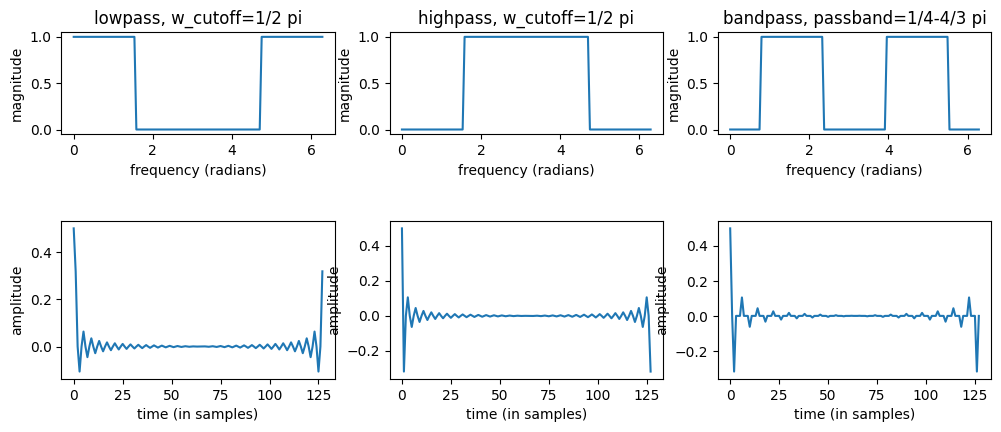

In [7]:
plt.figure(figsize=FIG_SIZE*np.array([1.5,1.5]))
Nf = 128  # 2 pi
xticks=np.linspace(0, np.pi*2, num=Nf, endpoint=True)

# draw frequence domain response
def plot_freqresponse(Y, freqticks):
    plt.plot(freqticks, Y)
    plt.xlabel('frequency (radians)')
    plt.ylabel('magnitude')

# draw time domain signal of the frequency response
def plot_timesignal(Y):
    plt.plot(np.fft.ifft(Y))
    plt.xlabel('time (in samples)')
    plt.ylabel('amplitude')

##############################################
# lowpass, cutoff frequency 1/2 pi
Y = np.concatenate((np.ones(Nf//4), np.zeros(Nf//2), np.ones(Nf//4)))**(1+0j)
plt.subplot(3,3,1)
plot_freqresponse(Y, xticks)
plt.title('lowpass, w_cutoff=1/2 pi')
plt.subplot(2,3,4)
plot_timesignal(Y)
    
##############################################
# highpass, cutoff frequency 1/2 pi
Y = np.concatenate((np.zeros(Nf//4), np.ones(Nf//2), np.zeros(Nf//4)))*(1+0j)
plt.subplot(3,3,2)
plot_freqresponse(Y, xticks)
plt.title('highpass, w_cutoff=1/2 pi')
plt.subplot(2,3,5)
plot_timesignal(Y)

##############################################
# lowpass, passband 1/2-3/4 pi
Y = np.concatenate((np.zeros(Nf//8), np.ones(Nf//4), np.zeros(Nf//8)))*(1+0j)
Y = np.concatenate((Y,Y))
plt.subplot(3,3,3)
plot_freqresponse(Y, xticks)
plt.title('bandpass, passband=1/4-4/3 pi')
plt.subplot(2,3,6)
plot_timesignal(Y)

---
### FIR filter implementation 

- lowpass, highpass, bandpass filter는 `scipy.signal` package 에 있는 함수를 사용하여 얻을 수 있다.
    1. 가장 일반적 [scipy.signal.firwin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html)
    2. [scipy.signal.firwin2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html)
    3. least squares [scipy.signal.firls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html)
    4. [scipy.signal.remez](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html)
- `MATLAB Signal Processing Toolbox`에도 `fir1`, `fir2`, `firls`, `firpm`, `remez` 등의 함수가 있다.(이쪽이 먼저임)
- 이중 가장 쉽게 사용할 수 있는 `firwin`을 이용하여 FIR 필터를 만들어 본다.

Text(0, 0.5, 'magnitude')

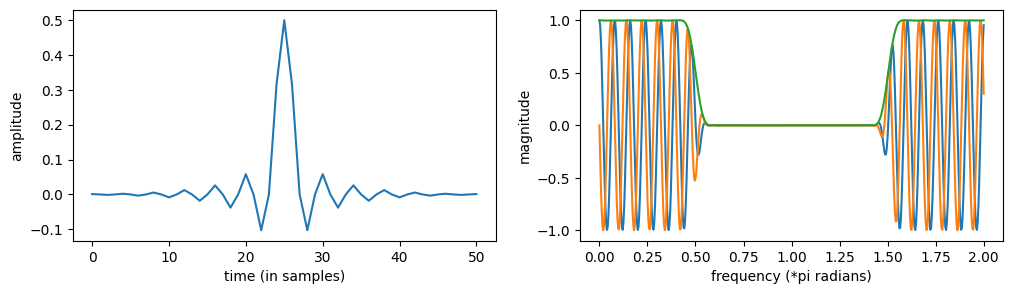

In [8]:
# scipy.signal.firwin(numtaps, cutoff, width=None, window='hamming', pass_zero=True, scale=True, nyq=None, fs=None)[source]
# FIR filter design using the window method.

# cutoff frequency 0.5 pi lowpass filter
a = signal.firwin(51, 0.5, window='hamming')
plt.figure(figsize=FIG_SIZE*np.array([1.5,1]))
plt.subplot(1,2,1)
plt.plot(a)
plt.xlabel('time (in samples)')
plt.ylabel('amplitude')
plt.subplot(1,2,2)
NFFT = 512
xticks=np.linspace(0, 2, num=NFFT, endpoint=True)
plt.plot(xticks, np.fft.fft(a, NFFT).real)
plt.plot(xticks, np.fft.fft(a, NFFT).imag)
plt.plot(xticks, np.abs(np.fft.fft(a, NFFT)))
plt.xlabel('frequency (*pi radians)')
plt.ylabel('magnitude')

1. time domain signal: 
    - real: symmetric at the center --> linear phase
        > A function is called linear phase if the phase response (output) of the filter is a linear function of frequency. 
        > Symmetric linear phase filters are very common, such as Wiener filters. 
        > An LTI system is minimum-phase if the system and its inverse are causal and stable (roots within a unit circle).
    - imaginary: anti-symmetric at the center --> real coefficient filter이기 때문에 모두 0
    - $A e^{ j \omega} = A ( \cos \omega + j \sin \omega) $
    - filter tab 은 홀수, 필터 order는 짝수로. 
    - 필터링 이후에는 order/2 만큼 shift 됨

2. frequency response
    - real, imaginary, 절대값을 그림 
    - __real__ symmetric at the center ($\pi$)
    - __imaginary__ anti-symmetric at the center ($\pi$)
    - __abs__ cutoff frequency $0.5 \pi$ 근처에서 부드럽게 변함 
    - Q: why tab = 51? (equivalently order = 50?)

filter order 를 바꿔 가면서 lowpass filter 비교 

In [9]:
def drawFIRWIN(numtabs, cutoff, pass_zero='lowpass', NFFT=512):
    # pass_zero = 'lowpass': lowpass
    # pass_zero = 'highpass': highpass
    a = signal.firwin(numtabs, cutoff, window='hamming', pass_zero=pass_zero)
    plt.subplot(1,2,1)
    plt.plot(a)
    plt.xlabel('time (in samples)')
    plt.ylabel('amplitude')
    plt.subplot(1,2,2)
    NFFT = max(numtabs, NFFT)
    xticks=np.linspace(0, 2, num=NFFT, endpoint=True)
    #plt.plot(xticks, np.fft.fft(a, NFFT).real)
    #plt.plot(xticks, np.fft.fft(a, NFFT).imag)
    plt.plot(xticks, np.abs(np.fft.fft(a, NFFT)))
    plt.xlabel('frequency (*pi radians)')
    plt.ylabel('magnitude')
    return a

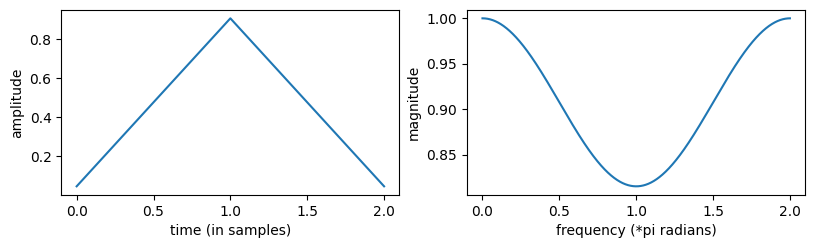

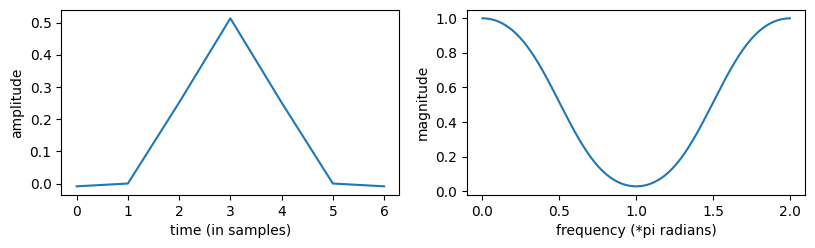

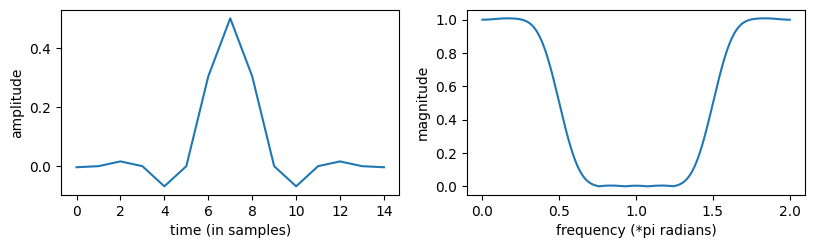

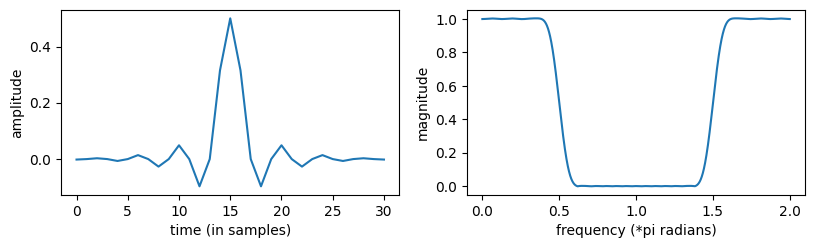

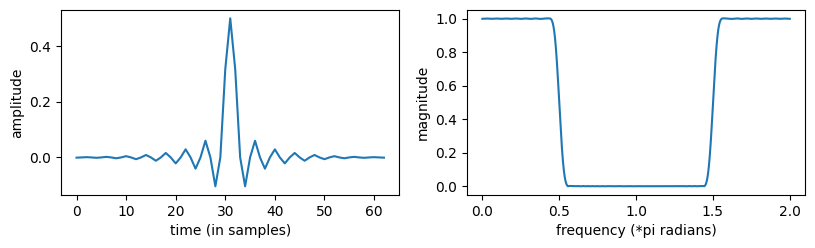

In [10]:
# lowpass
for nt in [3,7,15,31,63]:
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
    drawFIRWIN(nt, 0.5, NFFT=2048)    

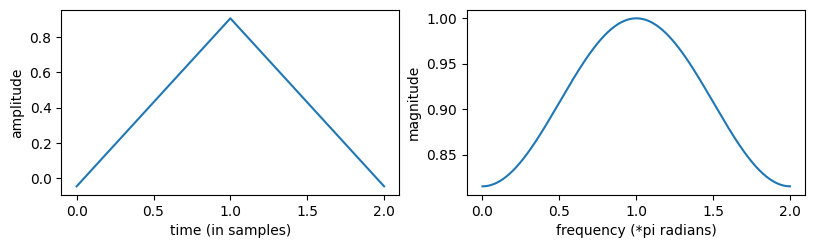

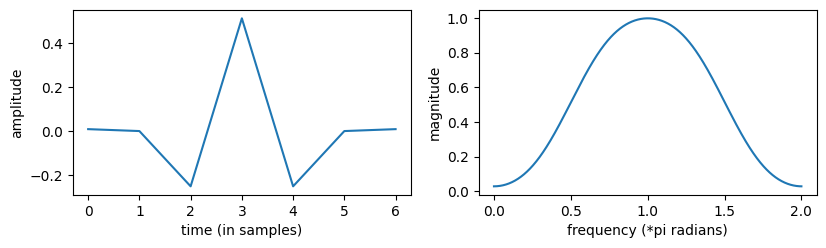

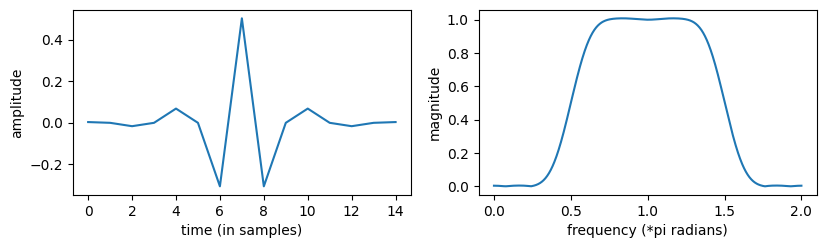

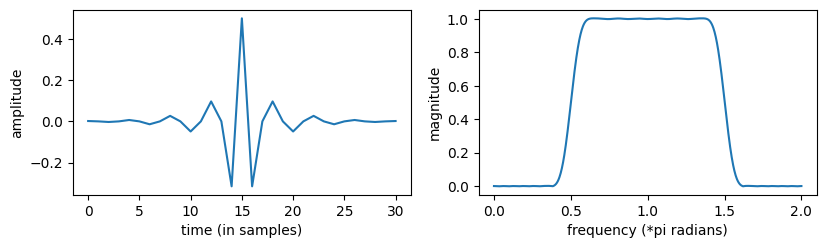

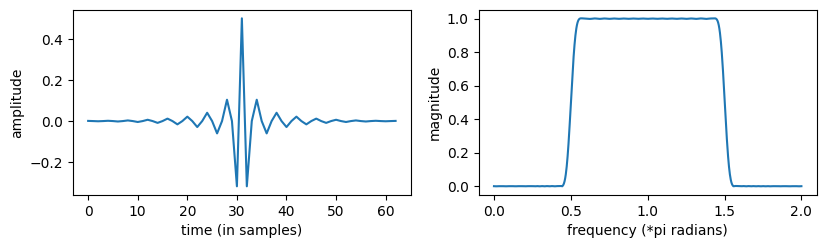

In [11]:
# highpass
for nt in [3,7,15,31,63]:
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
    drawFIRWIN(nt, 0.5, pass_zero='highpass', NFFT=1024)

- digital filter는 $z$ domain 에서 polynomial approximation. 따라서 order 가 높아질수록 sharp 하게 cutoff 가능.
- 다만 order 가 높아지면 직선이 구불구불해진다.
- lowpass filter는 averaging, highpass filter는 difference
- 모든 filter는 symmetric, shift order/2
- order 가 커지면 shift 도 커진다. 따라서 real-time system 에서는 이를 고려하여 정해야 함.

---
### FFT를 이용하여 linear phase FIR filter 만들기 

`scipy.signal` 에서 제공하지 않는 임의의 필터를 설계하는 방법 

1. $H(\omega) $ 원하는 frequency response를 0-pi 까지 만들기, NFFT/2+1 만큼
2. real 값 거울상으로 채워서 NFFT 채움
3. imaginary 값 모두 0으로 
2. IFFT $h[n] = F^{-1} H(\omega)$
5. 뒷 절반을 앞으로 이동 
6. $h[0]$ 를 중심으로 양쪽으로 order/2 만 선택
7. windowing (usually hamming)

`scipy.signal` 에서 제공하지 않는 임의의 필터를 설계하는 방법 
![FIRFFT design](figures/lab03_FIRFFT.png)

In [12]:
def getFIRFFT(H, order, winname=None):
    # H: NFFT/2+1
    NFFT = (len(H)-1)*2
    H = np.concatenate((H, H[-2:0:-1])) + np.zeros(NFFT)*(1j)
    h = np.fft.ifft(H, NFFT)
    order = min(NFFT-1, order)
    #h = np.concatenate((h[len(h)//2:], h[0:len(h)//2]))
    h = np.concatenate((h[(len(h)-order//2):], h[0:order//2+1]))
    if winname != None:
        win = librosa.filters.get_window(winname, order+1, fftbins=False)
        h = h*win
    return h.real

def drawFIRFFT(h, NFFT=512):
    plt.subplot(1,2,1)
    plt.plot(h)
    plt.xlabel('time (in samples)')
    plt.ylabel('amplitude')
    plt.subplot(1,2,2)
    NFFT = max(len(h), NFFT)
    xticks=np.linspace(0, 2, num=NFFT, endpoint=True)
    #plt.plot(xticks, np.fft.fft(a, NFFT).real)
    #plt.plot(xticks, np.fft.fft(a, NFFT).imag)
    plt.plot(xticks, np.abs(np.fft.fft(h, NFFT)))
    plt.xlabel('frequency (*pi radians)')
    plt.ylabel('magnitude')
    return h

getFIRFFT(np.arange(33), 10, 'hamming')

array([-0.02117231,  0.        , -0.28873613,  0.        , -5.91962644,
       16.        , -5.91962644,  0.        , -0.28873613,  0.        ,
       -0.02117231])

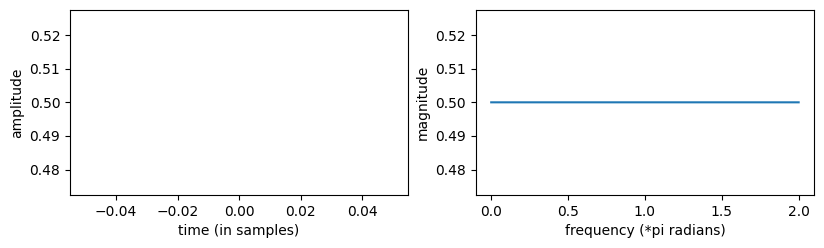

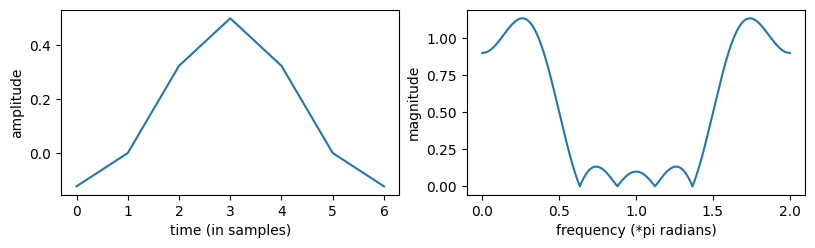

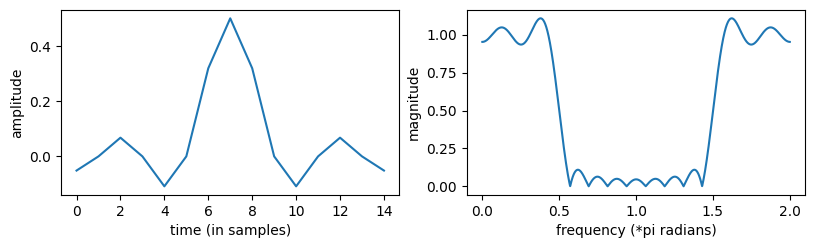

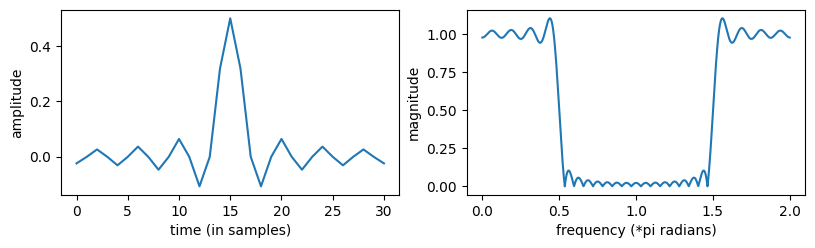

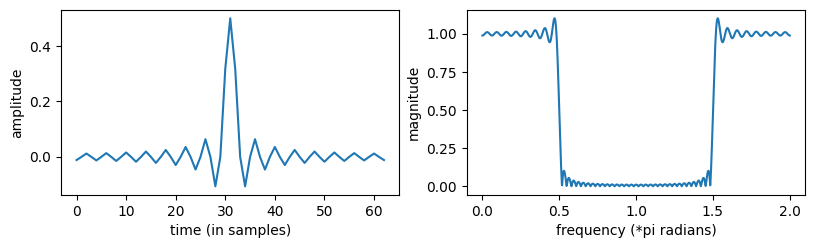

In [13]:
# lowpass 0.5, rectangular window
for order in [2, 6,14,30,62]:
    H = [1.0]*(order//2) + [0.0]*(order//2)
    h = getFIRFFT(np.array(H), order)
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
    drawFIRFFT(h, NFFT=2048)

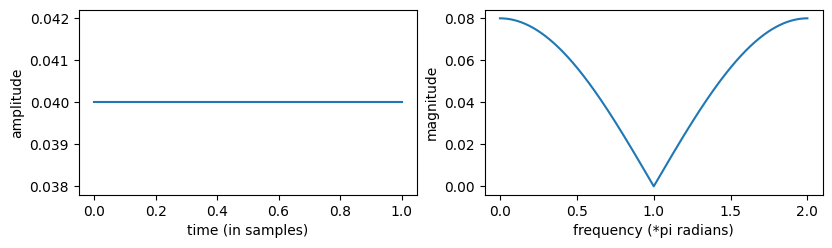

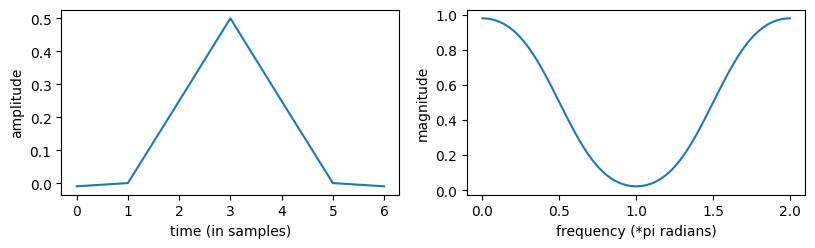

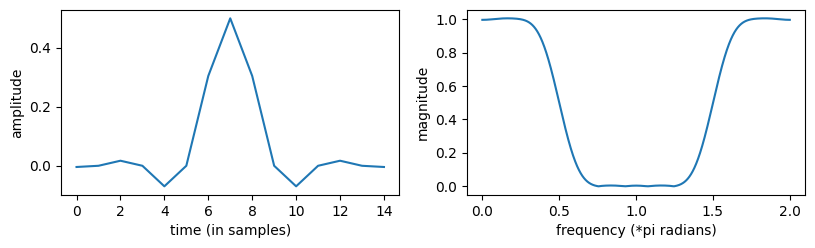

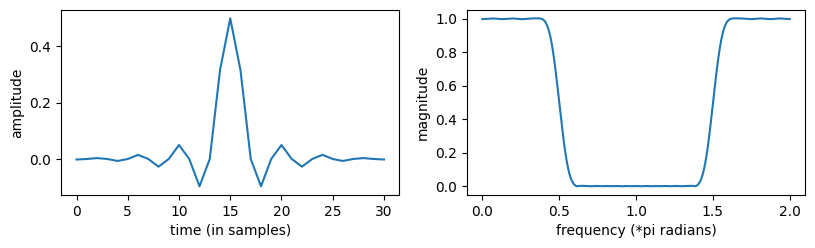

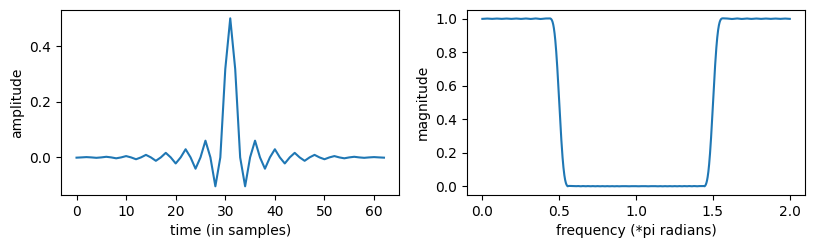

In [14]:
# lowpass 0.5, hamming window
# lowpass 0.5
for order in [2,6,14,30,62]:
    H = [1.0]*(order//2) + [0.0]*(order//2)
    h = getFIRFFT(np.array(H), order, winname='hamming')
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
    drawFIRFFT(h, NFFT=2048)

> hamming window를 써야 부드러운 response 를 얻을 수 있다.

audio file 에 적용

In [15]:
# returns decibel, with preventing 0 input
# note: input should be X(w) or x[n]
# dB = 20 log_10 (abs(x)) = 10 log_10 ( x^2 ) 
def decibel_sq_safe(x, epsilon=1e-10):
    return 10*np.log10(np.maximum(np.real(x*np.conj(x)),epsilon))

def drawspectrogram2(x, Nf, Ns=None, winname='hamming', minpercentile=80, isdbscale=True, isdraw=True):
    # Short-time Fourier transform with half-overlap 
    # Nf: analysis size
    # Ns: shift size 
    # NFFT: FFT size, power of 2
    if Ns==None: Ns=Nf//2
    num_frames = (len(x)-Nf)//Ns+1  # 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
    NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
    hNo = NFFT//2+1
    X = np.zeros((hNo,num_frames))
    
    # generate window
    if winname=='rect' or winname=='rectangular':
        win = np.ones(Nf)
    else:   # hamming, hann, etc.
        win = librosa.filters.get_window(winname, Nf, fftbins=True)
        
    # STFT
    for i in range(num_frames):
        y = np.fft.fft(win*x[(i*Ns):(i*Ns+Nf)], n=NFFT)
        y = y[:hNo]
        if isdbscale: y = decibel_sq_safe(y)
        else: y = np.abs(y)
        X[:,i] = y

    if isdraw:
        # 상위 80% 정도만 scale 한다. imshow의 vmin vmax 이용 
        vmax = np.max(X[:])
        vmin = np.percentile(X[:], minpercentile)
        specgram_axis = [0,float(len(x))/float(Fs),0,float(Fs)/2]
        plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower', extent=specgram_axis, vmax=vmax, vmin=vmin)
        plt.xlabel('time (seconds)')
        plt.ylabel('frequency (Hz)')
    
    return X

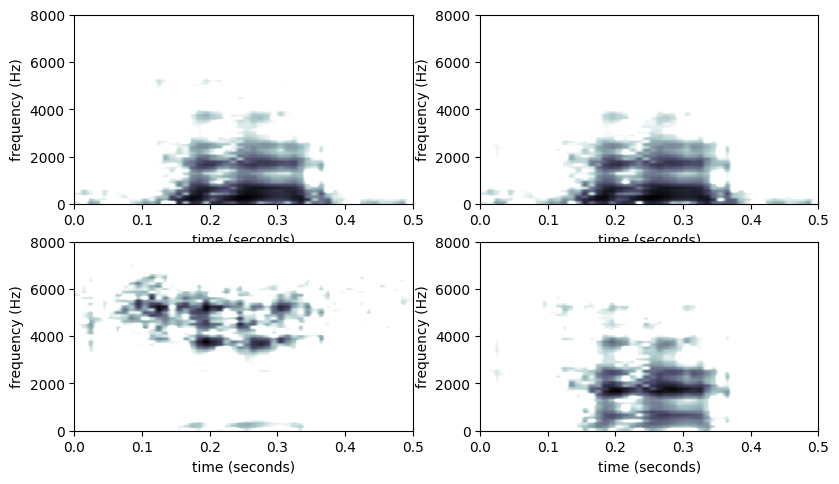

In [16]:
order = 14
plt.figure(figsize=FIG_SIZE*np.array([1.2,1.8]))

# original
plt.subplot(2,2,1)
X = drawspectrogram2(x, Nf, Ns, 'hamming')

# lowpass
H = [1.0]*(order//2) + [0.0]*(order//2)
h = getFIRFFT(np.array(H), order, winname='hamming')
x2 = signal.lfilter(h, [1], x)
plt.subplot(2,2,2)
X = drawspectrogram2(x2, Nf, Ns, 'hamming')

# highpass
H = [0.0]*(order//2) + [1.0]*(order//2)
h = getFIRFFT(np.array(H), order, winname='hamming')
x2 = signal.lfilter(h, [1], x)
plt.subplot(2,2,3)
X = drawspectrogram2(x2, Nf, Ns, 'hamming')

# bandpass
H = [0.0]*(order//4) + [1.0]*(order-order//4*2) + [0.0]*(order//4)
h = getFIRFFT(np.array(H), order, winname='hamming')
x2 = signal.lfilter(h, [1], x)
plt.subplot(2,2,4)
X = drawspectrogram2(x2, Nf, Ns, 'hamming')

---
## Programming assignments: Short Time Fourier transform with filtering

- 위의 `getFIRFFT` 함수를 보지 않고 작성해 본다.
- cutoff frequency 가 linear하게 올라가는 lowpass filter에 대해서 10ms shift, 3ms overlap의 trapezoidal (사다리꼴 overlap-add) 구현

## End of Lab 03